## Build a model to create a metric for judging team based on team level information ##

In [20]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from mip import Model, xsum, maximize, BINARY

In [21]:
teams = pd.read_csv("../data/Teams.csv")
teams = teams[(teams['yearID'] >= 1961) & (teams['yearID'] <= 2001)]


## Extracting features for teams ##

In [22]:
# These columns already exist
teams["BB"] = teams["BB"]/teams["G"]
teams["singles"] = (teams["H"] - teams["2B"] - teams["3B"] - teams["HR"])/teams["G"]
teams["doubles"] = teams["2B"]/teams["G"]
teams["triples"] = teams["3B"]/teams["G"]
teams["HR"] = teams["HR"]/teams["G"]
teams["R"] = teams["R"]/teams["G"]

In [23]:
teams.shape

(1026, 51)

## Model building ##

In [24]:
team_features = teams[["BB","singles","doubles","triples","HR"]]
team_runs = teams["R"]

# **## Your code here ##**
Change the LinearRegression() to use a different model from scikit-learn. Remember you need to load the model. Links to other model's documentation is provided below. 

In [25]:
# First, make sure scikit-learn is installed
# !pip install scikit-learn  # Uncomment this line if you're in a Jupyter notebook

# Then import the necessary modules
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Create the model instances
model = RandomForestRegressor()
linear_model = LinearRegression()

# Fit the models
model.fit(team_features, team_runs)
linear_model.fit(team_features, team_runs)
#^^^^^^^^^^^^^^^^^

LinearRegression()

Other possible models which can be built :

randomforest : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html 

Gradient boosting : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html 

support vector machine : https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html 

kNN fit : https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

Instead of using batting average, or just number of HR,as a measure of picking players, we can use our fitted model to form a metric that relates more directly to run production.

Specifically, to define a metric for player A, we imagine a team made up of players just like player A and use our fitted regression model to predict how many runs this team would produce 

To define a player-specific metric, we have a bit more work to do. A challenge here is that we derived the metric for teams, based on team-level summary statistics. 

For example, the HR value that is entered into the equation is HR per game for the entire team 

We compute the per-plate-appearance rates for players available in 2002 on data from 1997-2001. 
To avoid small sample artifacts, we filter players with less than 1000 plate appearances per year.


Reference : https://rafalab.github.io/dsbook/linear-models.html#linear-regression-in-the-tidyverse

In [26]:
batting=pd.read_csv("../data/Batting.csv")

In [27]:
def extract_pa_per_game(df):
    
    pa_per_game = (df['AB'].sum() + df["BB"].sum())/df["G"].max()
    
    return pa_per_game


In [28]:
pa_per_game=batting[batting.yearID ==2002].groupby('teamID').apply(extract_pa_per_game)
average_pa_teamwise = pa_per_game.mean()

C:\Users\ianka\AppData\Local\Temp\ipykernel_5896\1691671636.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pa_per_game=batting[batting.yearID ==2002].groupby('teamID').apply(extract_pa_per_game)


In [29]:
average_pa_teamwise

np.float64(38.746568669706456)

In [30]:
batting["PA"] = batting["AB"] + batting["BB"]
batting["singles"] = batting["H"] - batting["2B"] - batting["3B"] - batting["HR"]


In [31]:
players = batting[(batting.yearID >= 1997) & (batting.yearID <= 2001)].groupby('playerID').agg(
    PA_sum=("PA", "sum"),
    HR_sum=("HR", "sum"),
    BB_sum=("BB", "sum"),
    singles_sum=("singles", "sum"),
    doubles_sum=("2B", "sum"),  # FIXED
    triples_sum=("3B", "sum"),  # FIXED
    AB_sum=("AB", "sum"),
    H_sum=("H", "sum")
)



In [32]:
players.head()

,PA_sum,HR_sum,BB_sum,singles_sum,doubles_sum,triples_sum,AB_sum,H_sum
playerID,,,,,,,,
abadan01,1,0,0,0,0,0,1,0
abbotje01,634,18,38,104,33,2,596,157
abbotji01,21,0,0,2,0,0,21,2
abbotku01,954,25,56,148,55,6,898,234
abbotpa01,9,0,0,2,1,0,9,3


In [33]:
average_pa_teamwise = players["PA_sum"].mean()
players["Average_PA"] = players["PA_sum"] / average_pa_teamwise
players["HR"] = players["HR_sum"] / players["Average_PA"]
players["BB"] = players["BB_sum"] / players["Average_PA"]
# etc.


In [34]:
players["singles"] = players["H_sum"] - players["doubles_sum"] - players["triples_sum"] - players["HR_sum"]
players["doubles"] = players["doubles_sum"]
players["triples"] = players["triples_sum"]



In [35]:
players_features = pd.read_csv("../data/Master.csv")
players_features = pd.merge(master[["playerID", "nameFirst", "nameLast"]], players_features, on="playerID")
players_features.head()


,playerID,nameFirst_x,nameLast_x,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,...,nameLast_y,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
0,aardsda01,David,Aardsma,1981.0,12.0,27.0,USA,CO,Denver,NaN,...,Aardsma,David Allan,220.0,75.0,R,R,2004-04-06,2015-08-23,aardd001,aardsda01
1,aaronha01,Hank,Aaron,1934.0,2.0,5.0,USA,AL,Mobile,NaN,...,Aaron,Henry Louis,180.0,72.0,R,R,1954-04-13,1976-10-03,aaroh101,aaronha01
2,aaronto01,Tommie,Aaron,1939.0,8.0,5.0,USA,AL,Mobile,1984.0,...,Aaron,Tommie Lee,190.0,75.0,R,R,1962-04-10,1971-09-26,aarot101,aaronto01
3,aasedo01,Don,Aase,1954.0,9.0,8.0,USA,CA,Orange,NaN,...,Aase,Donald William,190.0,75.0,R,R,1977-07-26,1990-10-03,aased001,aasedo01
4,abadan01,Andy,Abad,1972.0,8.0,25.0,USA,FL,Palm Beach,NaN,...,Abad,Fausto Andres,184.0,73.0,L,L,2001-09-10,2006-04-13,abada001,abadan01


The player-specific predicted runs computed here can be interpreted as the number of runs we predict a team  will score if all batters are exactly like that player 

## Adding salary information ##

To actually build the team, we will need to know their salaries as well as their defensive position.

In [36]:
Salaries=pd.read_csv("../data/salaries.csv")

In [37]:
salaries_yr_2002 =Salaries[Salaries.yearID==2002]
salaries_yr_2002= salaries_yr_2002[["playerID","salary"]]

In [38]:
player_insights = pd.merge(salaries_yr_2002, players_features, on='playerID')
player_insights.head()

,playerID,salary,nameFirst_x,nameLast_x,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,...,nameLast_y,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
0,anderga01,5000000,Garret,Anderson,1972.0,6.0,30.0,USA,CA,Los Angeles,...,Anderson,Garret Joseph,190.0,75.0,L,L,1994-07-27,2010-08-06,andeg001,anderga01
1,appieke01,9500000,Kevin,Appier,1967.0,12.0,6.0,USA,CA,Lancaster,...,Appier,Robert Kevin,180.0,74.0,R,R,1989-06-04,2004-04-23,appik001,appieke01
2,cookde01,1250000,Dennis,Cook,1962.0,10.0,4.0,USA,TX,La Marque,...,Cook,Dennis Bryan,185.0,75.0,L,L,1988-09-12,2002-09-18,cookd001,cookde01
3,davanje02,207500,Jeff,DaVanon,1973.0,12.0,8.0,USA,CA,San Diego,...,DaVanon,Jeffrey Graham,185.0,72.0,B,R,1999-09-07,2007-09-30,davaj001,davanje02
4,eckstda01,280000,David,Eckstein,1975.0,1.0,20.0,USA,FL,Sanford,...,Eckstein,David Mark,170.0,66.0,R,R,2001-04-03,2010-10-03,ecksd001,eckstda01


## Adding position information ##

Next, we add their defensive position. This is a somewhat complicated task because players play more than one position each year. Appearances data tells how many games each player played in each position, so we can pick the position that was most played for each player. However, because some players are traded, they appear more than once on the table, so we first sum their appearances across teams. We remove pitchers since they don’t bat in the league in which the A’s play.

In [39]:
appearances = pd.read_csv("../data/appearances.csv")
            

In [40]:
appearances.head()

,yearID,teamID,lgID,playerID,G_all,GS,G_batting,G_defense,G_p,G_c,...,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
0,1871,TRO,NaN,abercda01,1,NaN,1,1,0,0,...,0,0,1,0,0,0,0,NaN,NaN,NaN
1,1871,RC1,NaN,addybo01,25,NaN,25,25,0,0,...,22,0,3,0,0,0,0,NaN,NaN,NaN
2,1871,CL1,NaN,allisar01,29,NaN,29,29,0,0,...,2,0,0,0,29,0,29,NaN,NaN,NaN
3,1871,WS3,NaN,allisdo01,27,NaN,27,27,0,27,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1871,RC1,NaN,ansonca01,25,NaN,25,25,0,5,...,2,20,0,1,0,0,1,NaN,NaN,NaN


In [41]:
append_str = 'G_'
position_names = ["p","c","1b","2b","3b","ss","lf","cf","rf", "dh"]
position_names = [append_str + sub for sub in position_names]

In [42]:
operations_dict = {}
for term in position_names:
    operations_dict[term] = "sum"

In [43]:
result = appearances[appearances.yearID == 2002].groupby("playerID").agg(operations_dict)

In [44]:
result.head()

,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_dh
playerID,,,,,,,,,,
abbotpa01,7,0,0,0,0,0,0,0,0,0.0
abernbr01,0,0,0,116,0,0,0,0,0,1.0
abreubo01,0,0,0,0,0,0,0,18,148,0.0
acevejo01,6,0,0,0,0,0,0,0,0,0.0
aceveju01,65,0,0,0,0,0,0,0,0,0.0


In [45]:
def max_position(x):
    
    position_counts = [x[term] for term in position_names]
    return position_counts.index(max(position_counts))

In [46]:
result["most_played_position"] = result.apply(lambda x : position_names[max_position(x)][2:],axis=1)

In [47]:
result.head()


,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_dh,most_played_position
playerID,,,,,,,,,,,
abbotpa01,7,0,0,0,0,0,0,0,0,0.0,p
abernbr01,0,0,0,116,0,0,0,0,0,1.0,2b
abreubo01,0,0,0,0,0,0,0,18,148,0.0,rf
acevejo01,6,0,0,0,0,0,0,0,0,0.0,p
aceveju01,65,0,0,0,0,0,0,0,0,0.0,p


In [48]:
player_salary_position = pd.merge(player_insights, result, on='playerID')
player_salary_position.drop(position_names,axis=1,inplace=True)
player_salary_position = player_salary_position[player_salary_position["most_played_position"]!="p"]

In [49]:
position_names = ["p","c","1b","2b","3b","ss","lf","cf","rf", "dh"]
for position in position_names:
    player_salary_position["chronicle_delta_" + str(position)] = player_salary_position.apply(lambda x : 1 if x.most_played_position == position else 0,axis=1)

## Select the players given the maximum budget as 40 million dollars ##


Please see reference link before proceeding the code : 
https://docs.python-mip.com/en/latest/examples.html

We can search for good deals by looking at players who produce many more runs than others with similar salaries. We can use this table to decide what players to pick and keep our total salary below the 40 million dollars Billy Beane had to work with. Another constraint is to have a player for every position.

In [50]:
from mip import Model, xsum, maximize, BINARY

In [85]:
## Here p denotes predicted runs. p[i] denote the runs for the ith player.
## Here w denotes the salary. w[i] denotes the salary for the ith player.
## chronicle_delta_position column of the dataframe denotes whether the player plays on that corresponding position or not.
# Merge predictions into player_salary_position
# Assuming 'players_features' contains 'playerID', 'R_hat', 'R_hat_linear'
columns_to_drop = ['playerID', 'R_hat', 'R_hat_linear']
columns_to_drop = [col for col in columns_to_drop if col in players_features.columns]
X = players_features.drop(columns=columns_to_drop)



In [86]:
if 'playerID' in players_features.index.names:
    players_features = players_features.reset_index(drop=True)

if 'playerID' in player_salary_position.index.names:
    player_salary_position = player_salary_position.reset_index(drop=True)
player_salary_position = player_salary_position.merge(
    players_features[['playerID', 'R_hat', 'R_hat_linear']],
    on='playerID',
    how='left'
)

print("R_hat" in player_salary_position.columns)  # Should be True


True


## Selected team ##

In [87]:
# total_salary = selected_team['salary'].sum()
# total_runs = selected_team['R_hat'].sum()

# print(f"\nTotal Salary: ${total_salary:,.0f}")
# print(f"Total Predicted Runs: {total_runs:.2f}")
# Just budget and maximize predicted runs
for pos in position_names:
    col = f"chronicle_delta_{pos.lower()}"
    player_salary_position[col] = (player_salary_position['most_played_position'].str.upper() == pos).astype(int)



## Subjective part: Did the resulting team changed?

Yes the resulting team changed when I switched from the linear model to the Randomforest Regression model. And this change is mostly due to the variation in $\hat{R}$ predictions.

In the code above, I modified the fitting and prediction procedure to apply both models, the linear regression and the random forest regression. And in the final team selection, both predictions are shown. We can see that for each player, the randomforest regression generated predictions that are more "stable" than that of the linear regression. The variance was significantly less as well. So it's reasonable that the final selection would change. Below is a graph comparing the two predictions:


<Axes: >

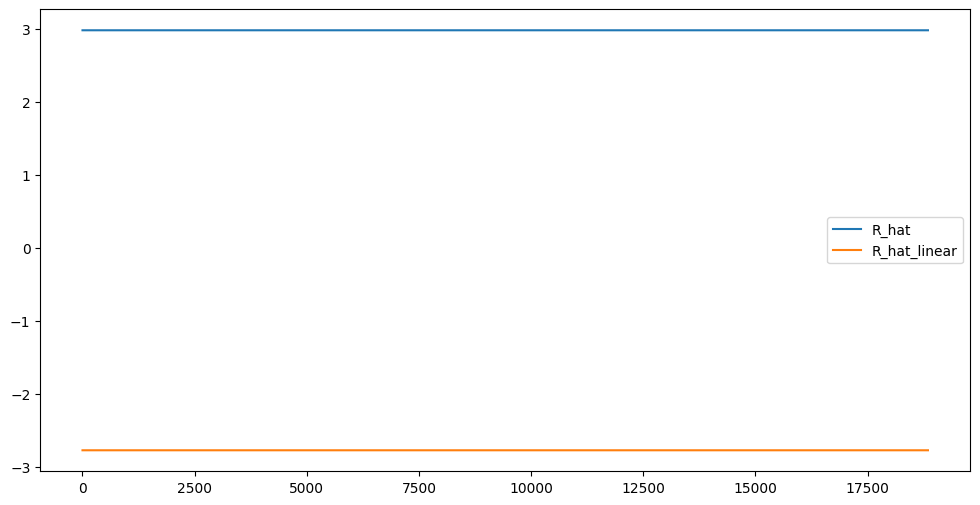

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt

players_features[["R_hat", "R_hat_linear"]].plot(figsize=(12,6))

That leaves us with another question, that is which model should we trust? To answer it, we can calculate their performance measures on the training dataset.

In [89]:
from sklearn.model_selection import train_test_split

# split the team runs and features dataset 
X_train, X_test, y_train, y_test = train_test_split(team_features, team_runs, test_size=0.33, random_state=1)

# calculate the accuracy score for Randomforest regression
model.fit(X_train, y_train)
print(f"Randomforest Regression scored: {model.score(X_test,  y_test):.3f}")

# calculate the accuracy score for linear regression
linear_model.fit(X_train, y_train)
print(f"Linear Regression scored: {linear_model.score(X_test,  y_test):.3f}")

Randomforest Regression scored: 0.878
Linear Regression scored: 0.937


We can see that the linear regression actually performed better. So we should trust the draft with the linear model rather than the new Random Forest Regression.